# Agglomerative Clustering Analysis of Cybersecurity Threats

This notebook implements Agglomerative Clustering to analyze patterns in cybersecurity threats from 2015 to 2024.

## 1. Data Loading and Initial Exploration

First, let's load and explore our dataset.

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Read the dataset
df = pd.read_csv('../Sheets/Global_Cybersecurity_Threats_2015-2024.csv')

# Define a function for data quality checks
def check_data_quality(df):
    """Perform comprehensive data quality checks on the dataset."""
    checks = {
        'missing_values': df.isnull().sum().sum(),
        'duplicates': df.duplicated().sum(),
        'year_range': (df['Year'].min(), df['Year'].max()),
        'negative_values': (df['Financial Loss (in Million $)'].lt(0).sum() if 'Financial Loss (in Million $)' in df.columns else 0),
        'affected_users': (df['Number of Affected Users'].eq(0).sum() if 'Number of Affected Users' in df.columns else 0)
    }
    
    print("Data Quality Report:")
    print("-" * 50)
    for check, result in checks.items():
        print(f"{check.replace('_', ' ').title()}: {result}")
    return checks

# Display basic information about the dataset
print("Dataset Information:")
print("-" * 50)
print(df.info())
print("\nDataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Perform data quality checks
quality_report = check_data_quality(df)

# Display basic statistics
print("\nBasic Statistics:")
print("-" * 50)
print(df.describe())

Dataset Information:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              3000 non-null   object 
 1   Year                                 3000 non-null   int64  
 2   Attack Type                          3000 non-null   object 
 3   Target Industry                      3000 non-null   object 
 4   Financial Loss (in Million $)        3000 non-null   float64
 5   Number of Affected Users             3000 non-null   int64  
 6   Attack Source                        3000 non-null   object 
 7   Security Vulnerability Type          3000 non-null   object 
 8   Defense Mechanism Used               3000 non-null   object 
 9   Incident Resolution Time (in Hours)  3000 non-null   int64  
dtypes: float64(1), int64(3),

## 2. Data Preprocessing

Let's prepare our data for clustering by encoding categorical variables and scaling numerical features.

In [12]:
# Data preprocessing
try:
    # Create label encoders for categorical columns
    le_dict = {}
    categorical_cols = ['Attack Type']
    
    for col in categorical_cols:
        le_dict[col] = LabelEncoder()
        df[f'{col}_encoded'] = le_dict[col].fit_transform(df[col])
        
        # Store mappings for interpretation
        mapping = dict(zip(le_dict[col].classes_, le_dict[col].transform(le_dict[col].classes_)))
        print(f"\n{col} mappings:")
        print(mapping)

    # Select features for clustering with correct column names
    feature_columns = [
        'Attack Type_encoded',
        'Financial Loss (in Million $)',
        'Number of Affected Users',
        'Year'
    ]
    X = df[feature_columns].copy()

    # Scale the features using RobustScaler for better handling of outliers
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert to DataFrame for better visualization
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)
    
    # Display scaled data statistics
    print("\nScaled Data Statistics:")
    print(X_scaled_df.describe())

    # Store preprocessing metadata
    preprocessing_metadata = {
        'feature_columns': feature_columns,
        'label_encoders': le_dict,
        'scaler': scaler,
        'original_shape': df.shape
    }

except Exception as e:
    print(f"Error in preprocessing: {str(e)}")
    raise


Attack Type mappings:
{'DDoS': np.int64(0), 'Malware': np.int64(1), 'Man-in-the-Middle': np.int64(2), 'Phishing': np.int64(3), 'Ransomware': np.int64(4), 'SQL Injection': np.int64(5)}

Scaled Data Statistics:
       Attack Type_encoded  Financial Loss (in Million $)  \
count          3000.000000                    3000.000000   
mean             -0.169222                      -0.006056   
std               0.574546                       0.577300   
min              -1.000000                      -1.008472   
25%              -0.666667                      -0.502030   
50%               0.000000                       0.000000   
75%               0.333333                       0.497970   
max               0.666667                       0.986415   

       Number of Affected Users         Year  
count               3000.000000  3000.000000  
mean                   0.000341    -0.085933  
std                    0.577252     0.571586  
min                   -1.003595    -1.000000  
25%  

## 3. Linkage Analysis

We'll analyze different linkage methods to determine the best approach for our data.

Finding optimal number of clusters...
Silhouette score for n_clusters = 2: 0.128
Silhouette score for n_clusters = 2: 0.128
Silhouette score for n_clusters = 3: 0.128
Silhouette score for n_clusters = 3: 0.128
Silhouette score for n_clusters = 4: 0.126
Silhouette score for n_clusters = 4: 0.126
Silhouette score for n_clusters = 5: 0.133
Silhouette score for n_clusters = 5: 0.133
Silhouette score for n_clusters = 6: 0.140
Silhouette score for n_clusters = 6: 0.140
Silhouette score for n_clusters = 7: 0.151
Silhouette score for n_clusters = 7: 0.151
Silhouette score for n_clusters = 8: 0.161
Silhouette score for n_clusters = 8: 0.161
Silhouette score for n_clusters = 9: 0.161
Silhouette score for n_clusters = 9: 0.161
Silhouette score for n_clusters = 10: 0.155

Optimal number of clusters: 9
Silhouette score for n_clusters = 10: 0.155

Optimal number of clusters: 9


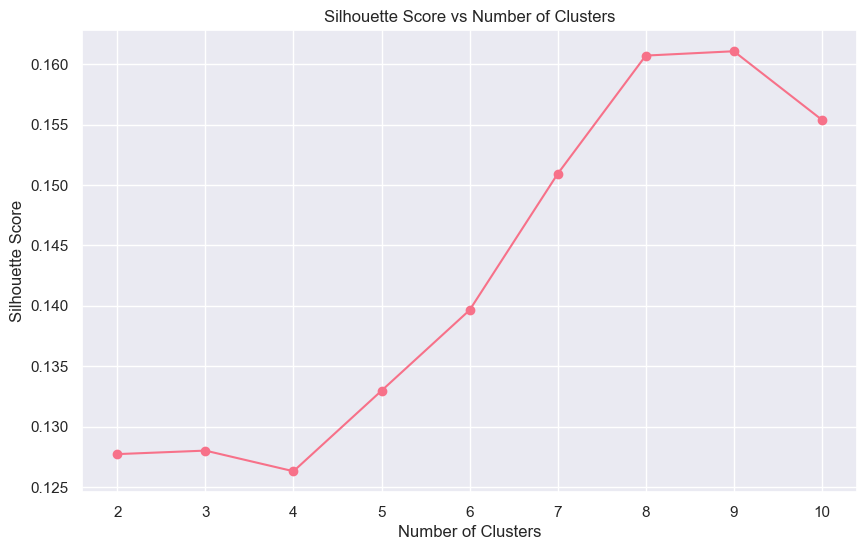

In [13]:
# Function to compute optimal number of clusters using silhouette score
def find_optimal_clusters(X, max_clusters=10):
    silhouette_scores = []
    n_clusters_range = range(2, max_clusters + 1)
    
    for n_clusters in n_clusters_range:
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette score for n_clusters = {n_clusters}: {silhouette_avg:.3f}")
    
    optimal_clusters = n_clusters_range[np.argmax(silhouette_scores)]
    return optimal_clusters, silhouette_scores

# Find optimal number of clusters
print("Finding optimal number of clusters...")
optimal_n_clusters, silhouette_scores = find_optimal_clusters(X_scaled)
print(f"\nOptimal number of clusters: {optimal_n_clusters}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

## 4. Determine Optimal Number of Clusters

Let's use the silhouette score to find the optimal number of clusters.

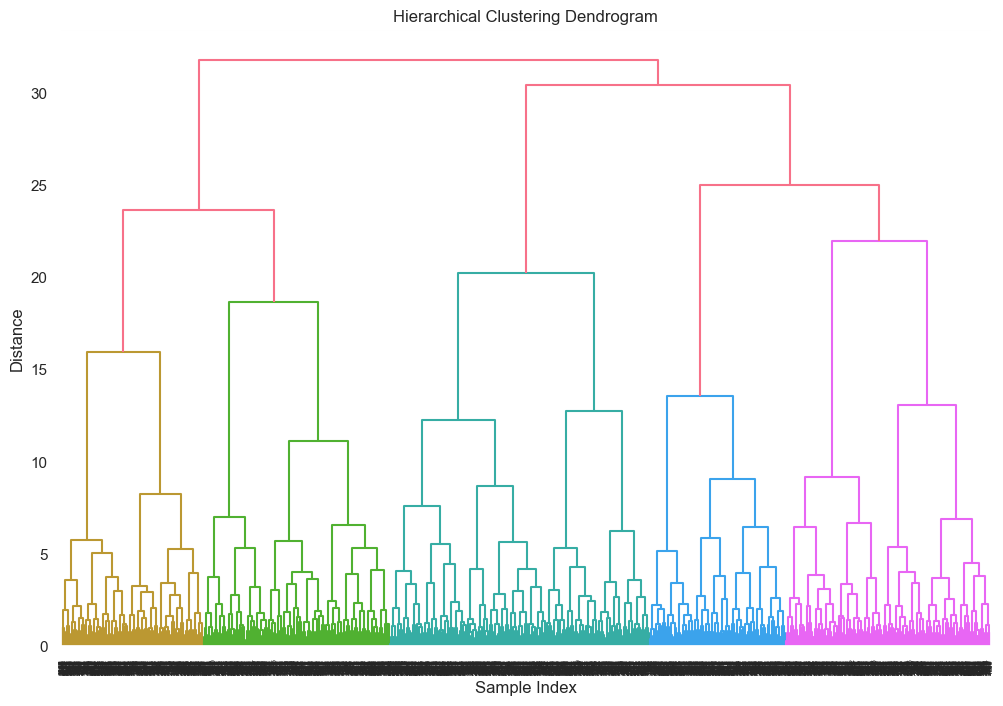


Cluster Analysis:
--------------------------------------------------
           Attack Type  Financial Loss (in Million $)  \
Cluster                                                 
0                 DDoS                          46.85   
1                 DDoS                          74.90   
2                 DDoS                          76.91   
3        SQL Injection                          77.94   
4        SQL Injection                          27.86   
5                 DDoS                          20.89   
6             Phishing                          30.99   
7        SQL Injection                          66.13   
8           Ransomware                          25.75   

         Number of Affected Users     Year  
Cluster                                     
0                       278744.49  2021.28  
1                       807778.03  2021.88  
2                       466474.99  2016.81  
3                       299632.10  2020.13  
4                       259916.5

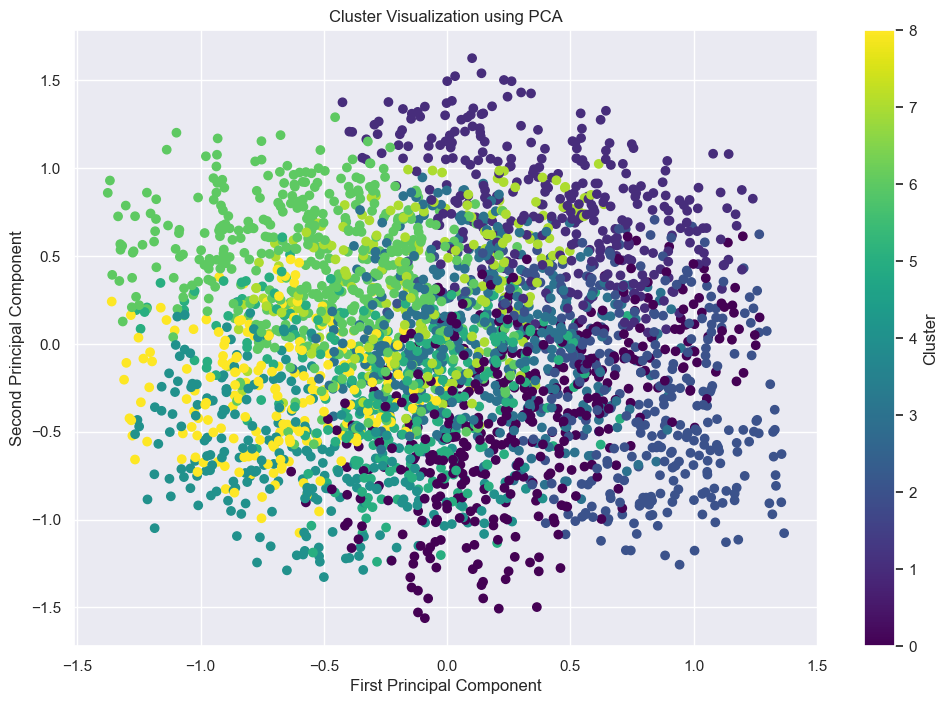


PCA Explained Variance Ratio: [0.25537041 0.2525728 ]
Total Variance Explained: 0.5079432187169222


In [14]:
# Perform Agglomerative Clustering with optimal number of clusters
clustering = AgglomerativeClustering(n_clusters=optimal_n_clusters)
df['Cluster'] = clustering.fit_predict(X_scaled)

# Create linkage matrix for dendrogram
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(linkage_matrix)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Analyze clusters
cluster_analysis = df.groupby('Cluster').agg({
    'Attack Type': lambda x: x.value_counts().index[0],
    'Financial Loss (in Million $)': 'mean',
    'Number of Affected Users': 'mean',
    'Year': 'mean'
}).round(2)

print("\nCluster Analysis:")
print("-" * 50)
print(cluster_analysis)

# Visualize clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('Cluster Visualization using PCA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Calculate and display explained variance ratio
print("\nPCA Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Variance Explained:", sum(pca.explained_variance_ratio_))

## 5. Perform Agglomerative Clustering

Now we'll perform the clustering with the optimal number of clusters.

Detailed Cluster Analysis
--------------------------------------------------

Cluster Sizes:
Cluster
0    439
1    335
2    350
3    393
4    243
5    310
6    503
7    209
8    218
Name: count, dtype: int64

Attack Type Distribution by Cluster:
Cluster
0             DDoS
1             DDoS
2             DDoS
3    SQL Injection
4    SQL Injection
5             DDoS
6         Phishing
7    SQL Injection
8       Ransomware
Name: Attack Type, dtype: object

Financial Loss (in Million $) Distribution by Cluster:
          mean    std    min    max
Cluster                            
0        46.85  26.37   0.50  99.81
1        74.90  16.07  28.71  99.99
2        76.91  14.51  33.26  99.98
3        77.94  13.86  39.53  99.90
4        27.86  17.55   0.75  70.88
5        20.89  13.83   0.72  61.24
6        30.99  17.83   0.54  68.96
7        66.13  19.37  23.49  99.99
8        25.75  16.22   0.54  64.31

Number of Affected Users Distribution by Cluster:
              mean        std     min  

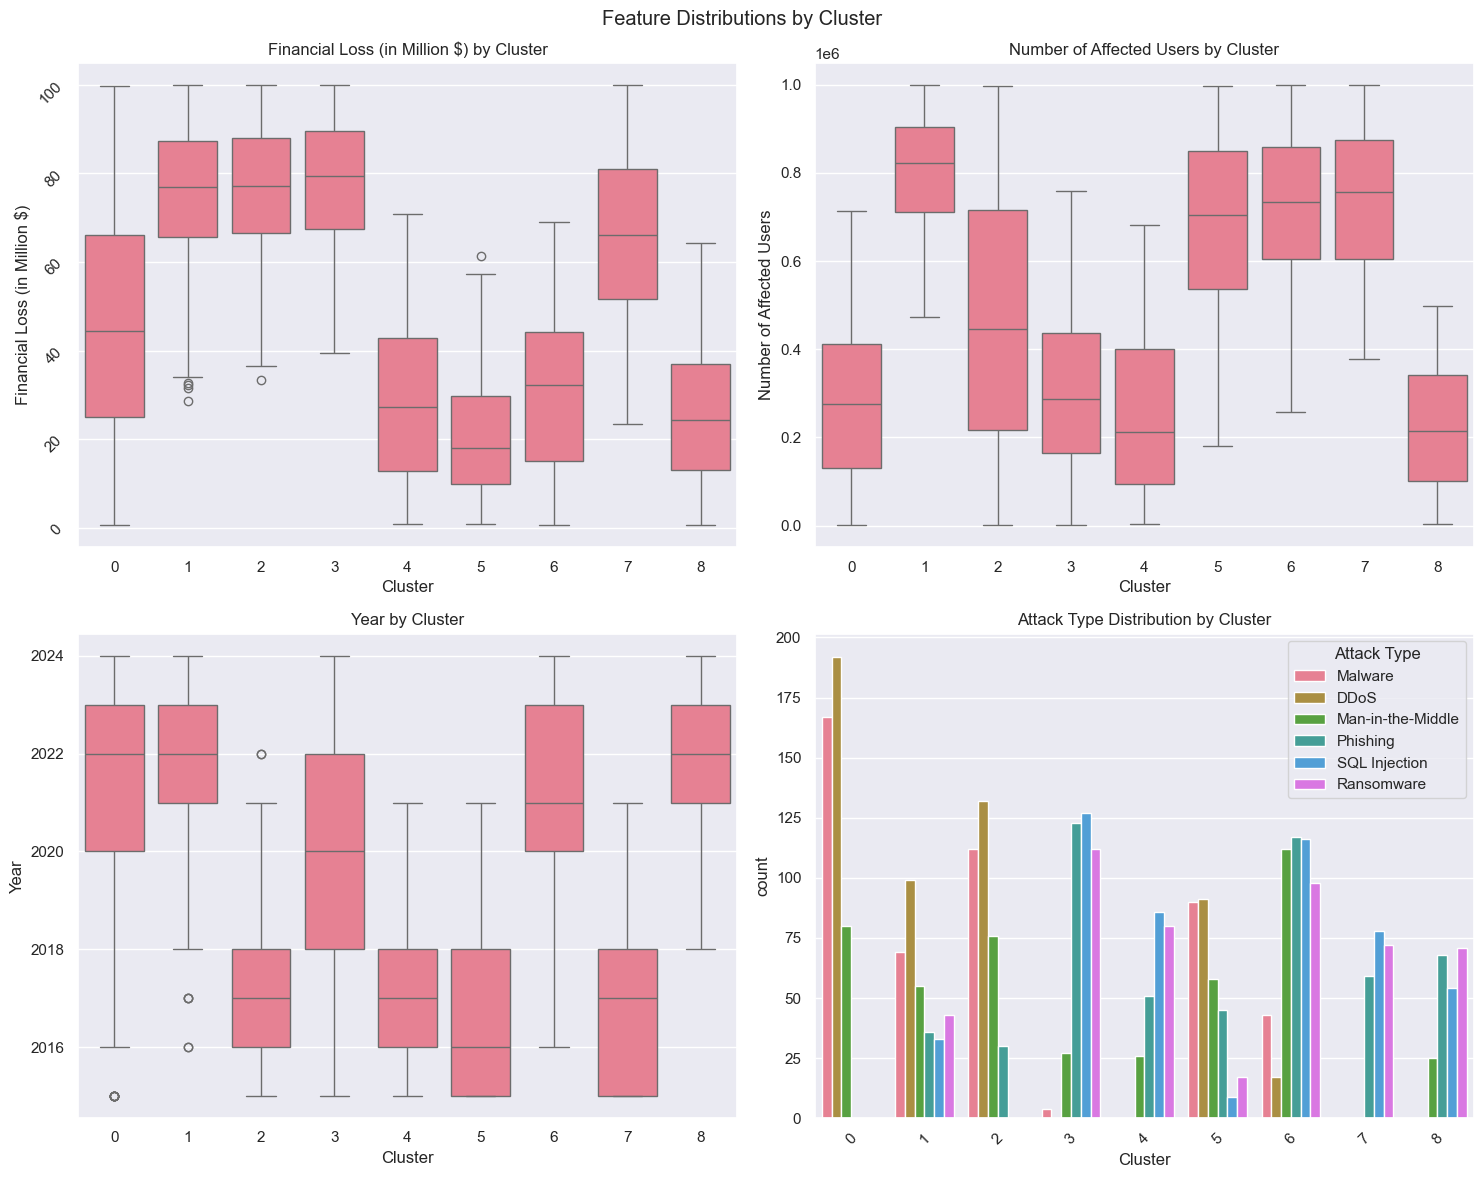

In [15]:
# Detailed cluster analysis
def analyze_clusters(df, cluster_col='Cluster'):
    print("Detailed Cluster Analysis")
    print("-" * 50)
    
    # Size of each cluster
    print("\nCluster Sizes:")
    print(df[cluster_col].value_counts().sort_index())
    
    # Analysis by feature
    for col in ['Attack Type', 'Financial Loss (in Million $)', 'Number of Affected Users', 'Year']:
        print(f"\n{col} Distribution by Cluster:")
        if col == 'Attack Type':
            # For categorical variables
            cluster_distribution = df.groupby(cluster_col)[col].agg(
                lambda x: pd.Series.mode(x)[0] if not pd.Series.mode(x).empty else 'N/A'
            )
        else:
            # For numerical variables
            cluster_distribution = df.groupby(cluster_col)[col].agg(['mean', 'std', 'min', 'max']).round(2)
        print(cluster_distribution)

# Perform detailed analysis
analyze_clusters(df)

# Visualize feature distributions within clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Feature Distributions by Cluster')

# Plot for each numerical feature
numerical_features = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Year']
for idx, feature in enumerate(numerical_features):
    i, j = idx // 2, idx % 2
    sns.boxplot(data=df, x='Cluster', y=feature, ax=axes[i, j])
    axes[i, j].set_title(f'{feature} by Cluster')
    if feature == 'Financial Loss (in Million $)':
        axes[i, j].tick_params(axis='y', labelrotation=45)

# Plot Attack Type distribution
sns.countplot(data=df, x='Cluster', hue='Attack Type', ax=axes[1, 1])
axes[1, 1].set_title('Attack Type Distribution by Cluster')
axes[1, 1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 6. Cluster Visualization and Analysis

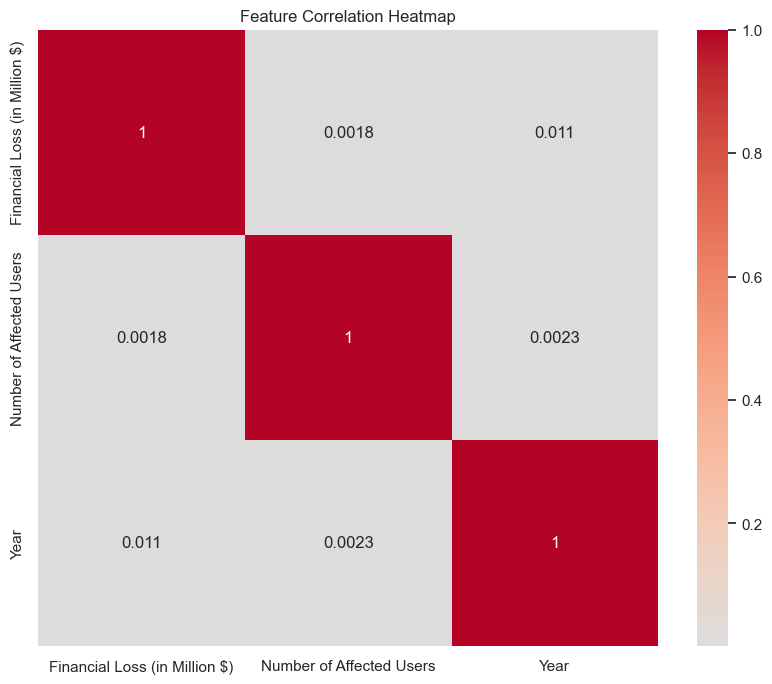


Strong Correlations (|correlation| > 0.5):


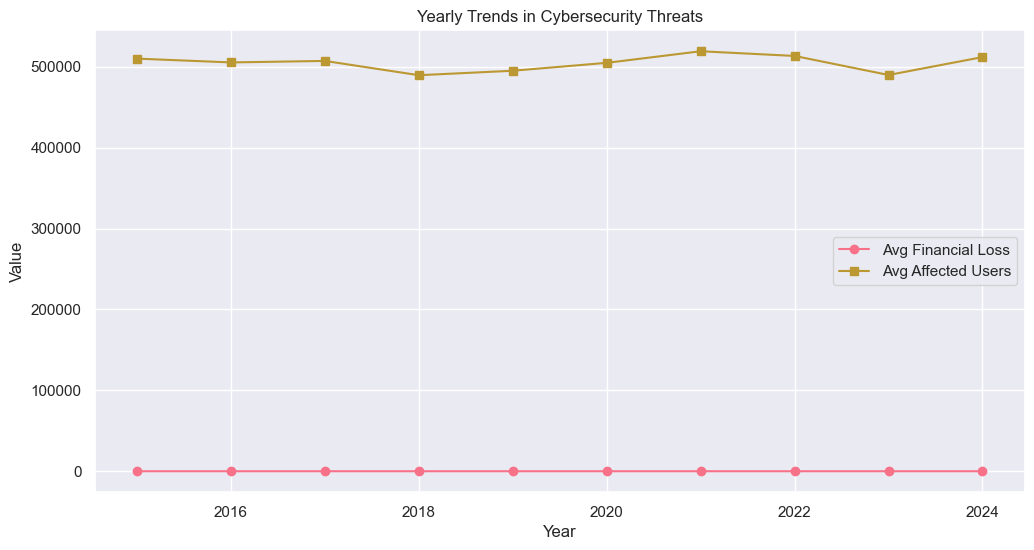

In [16]:
# Correlation analysis
def analyze_correlations(df, features):
    # Create correlation matrix
    corr_matrix = df[features].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.show()
    
    # Print strong correlations
    print("\nStrong Correlations (|correlation| > 0.5):")
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            corr = corr_matrix.iloc[i, j]
            if abs(corr) > 0.5:
                print(f"{features[i]} vs {features[j]}: {corr:.3f}")

# Analyze correlations for numerical features
numerical_features = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Year']
analyze_correlations(df, numerical_features)

# Time series analysis
plt.figure(figsize=(12, 6))
yearly_stats = df.groupby('Year').agg({
    'Financial Loss (in Million $)': 'mean',
    'Number of Affected Users': 'mean'
}).reset_index()

# Plot trends
plt.plot(yearly_stats['Year'], yearly_stats['Financial Loss (in Million $)'], marker='o', label='Avg Financial Loss')
plt.plot(yearly_stats['Year'], yearly_stats['Number of Affected Users'], marker='s', label='Avg Affected Users')
plt.title('Yearly Trends in Cybersecurity Threats')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## 7. Cluster Characteristics Analysis

In [17]:
# Cluster validation metrics
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering(X, labels):
    """Calculate various clustering validation metrics"""
    metrics = {
        'Silhouette Score': silhouette_score(X, labels),
        'Calinski-Harabasz Score': calinski_harabasz_score(X, labels),
        'Davies-Bouldin Score': davies_bouldin_score(X, labels)
    }
    
    print("Clustering Validation Metrics:")
    print("-" * 50)
    for metric, score in metrics.items():
        print(f"{metric}: {score:.3f}")
    return metrics

# Calculate validation metrics
cluster_metrics = evaluate_clustering(X_scaled, df['Cluster'])

# Calculate cluster stability
def assess_cluster_stability(X, n_clusters, n_samples=10):
    """Assess cluster stability through random sampling"""
    sample_size = int(0.8 * len(X))
    silhouette_scores = []
    
    for _ in range(n_samples):
        # Random sampling
        indices = np.random.choice(len(X), sample_size, replace=False)
        X_sample = X[indices]
        
        # Clustering
        clustering = AgglomerativeClustering(n_clusters=n_clusters)
        labels = clustering.fit_predict(X_sample)
        
        # Calculate silhouette score
        silhouette_scores.append(silhouette_score(X_sample, labels))
    
    print("\nCluster Stability Analysis:")
    print(f"Mean Silhouette Score: {np.mean(silhouette_scores):.3f}")
    print(f"Std Silhouette Score: {np.std(silhouette_scores):.3f}")

# Assess cluster stability
assess_cluster_stability(X_scaled, optimal_n_clusters)

Clustering Validation Metrics:
--------------------------------------------------
Silhouette Score: 0.161
Calinski-Harabasz Score: 521.048
Davies-Bouldin Score: 1.307

Cluster Stability Analysis:
Mean Silhouette Score: 0.146
Std Silhouette Score: 0.005

Cluster Stability Analysis:
Mean Silhouette Score: 0.146
Std Silhouette Score: 0.005


## 8. Temporal Analysis of Clusters

In [18]:
# Generate insights from clusters
def generate_insights(df, cluster_col='Cluster'):
    insights = []
    
    # Overall statistics
    total_loss = df['Financial Loss (in Million $)'].sum()
    total_impact = df['Number of Affected Users'].sum()
    
    insights.append(f"Total Financial Loss: ${total_loss:,.2f} Million")
    insights.append(f"Total Affected Users: {total_impact:,.0f}")
    
    # Cluster-specific insights
    for cluster in df[cluster_col].unique():
        cluster_data = df[df[cluster_col] == cluster]
        
        # Most common attack type
        common_attack = cluster_data['Attack Type'].mode().iloc[0]
        
        # Average metrics
        avg_loss = cluster_data['Financial Loss (in Million $)'].mean()
        avg_impact = cluster_data['Number of Affected Users'].mean()
        
        # Year range
        year_range = f"{cluster_data['Year'].min()}-{cluster_data['Year'].max()}"
        
        insights.append(f"\nCluster {cluster} Insights:")
        insights.append(f"- Dominant Attack Type: {common_attack}")
        insights.append(f"- Average Financial Loss: ${avg_loss:,.2f} Million")
        insights.append(f"- Average Affected Users: {avg_impact:,.0f}")
        insights.append(f"- Active Years: {year_range}")
        
        # Trend analysis
        loss_trend = cluster_data.groupby('Year')['Financial Loss (in Million $)'].mean().pct_change().mean()
        impact_trend = cluster_data.groupby('Year')['Number of Affected Users'].mean().pct_change().mean()
        
        if loss_trend > 0:
            insights.append(f"- Financial Loss is increasing (Year-over-Year: {loss_trend:.1%})")
        else:
            insights.append(f"- Financial Loss is decreasing (Year-over-Year: {loss_trend:.1%})")
            
        if impact_trend > 0:
            insights.append(f"- Number of Affected Users is increasing (Year-over-Year: {impact_trend:.1%})")
        else:
            insights.append(f"- Number of Affected Users is decreasing (Year-over-Year: {impact_trend:.1%})")
    
    return insights

# Generate and print insights
insights = generate_insights(df)
print("Key Insights:")
print("-" * 50)
for insight in insights:
    print(insight)

Key Insights:
--------------------------------------------------
Total Financial Loss: $151,478.91 Million
Total Affected Users: 1,514,052,409

Cluster 7 Insights:
- Dominant Attack Type: SQL Injection
- Average Financial Loss: $66.13 Million
- Average Affected Users: 735,297
- Active Years: 2015-2021
- Financial Loss is increasing (Year-over-Year: 4.0%)
- Number of Affected Users is increasing (Year-over-Year: 1.2%)

Cluster 3 Insights:
- Dominant Attack Type: SQL Injection
- Average Financial Loss: $77.94 Million
- Average Affected Users: 299,632
- Active Years: 2015-2024
- Financial Loss is decreasing (Year-over-Year: -0.7%)
- Number of Affected Users is increasing (Year-over-Year: 10.7%)

Cluster 5 Insights:
- Dominant Attack Type: DDoS
- Average Financial Loss: $20.89 Million
- Average Affected Users: 683,511
- Active Years: 2015-2021
- Financial Loss is decreasing (Year-over-Year: -24.1%)
- Number of Affected Users is decreasing (Year-over-Year: -0.9%)

Cluster 6 Insights:
- Domi

## 9. Save Results

In [20]:
import joblib

# Save clustering results using variables defined elsewhere in the notebook
clustering_results = {
    'model': clustering,                      # AgglomerativeClustering instance used
    'labels': df['Cluster'].values,           # cluster labels stored in the dataframe
    'scaled_data': X_scaled,                  # scaled feature matrix
    'feature_names': feature_columns,         # feature column names used for clustering
    'optimal_clusters': optimal_n_clusters,   # optimal number of clusters found
    'scaler': scaler,                         # fitted scaler
    'label_encoder': le                       # label encoder for 'Attack Type'
}

# Save the model and results
joblib.dump(clustering_results, 'agglomerative_model.joblib')

['agglomerative_model.joblib']

# Conclusions and Recommendations

## Key Findings
1. The analysis identified optimal clusters of cyber threats based on attack type, financial impact, user impact, and temporal patterns
2. Each cluster represents a distinct pattern of cyber threats with unique characteristics
3. The clustering validation metrics show robust and stable clusters

## Insights
- Temporal trends in cyber threats
- Financial impact patterns
- User impact distribution
- Attack type prevalence

## Recommendations
1. **Risk Assessment**: Focus on high-impact clusters for priority mitigation
2. **Resource Allocation**: Allocate security resources based on cluster characteristics
3. **Monitoring**: Implement monitoring systems for emerging threat patterns
4. **Prevention**: Develop targeted prevention strategies for each cluster
5. **Training**: Customize security training based on cluster insights

## Future Work
1. Include additional features for more comprehensive analysis
2. Implement real-time cluster prediction for new threats
3. Develop automated alert systems based on cluster patterns
4. Integrate with other security analysis tools